# Análisis de Redes Sociales con Python
## Proyecto

Este proyecto consta de dos partes:
1. Captura de datos
    * Conexión a la API de Twitter para obtención de datos
2. Análisis de datos:
    * Generación de un grafo a partir de los datos capturados
    * Identificación de los 'intermediadores' de la red
    * Identificación de los 'influencers' de la red
    * Identificación de las comunidades

# 1. Captura de Datos
-------

En este apartado tendremos que:

1. Conectarnos a la API de Twitter para recopilar datos
2. Procesar los datos y generar un fichero en formato edgelist de relaciones entre usuarios

## Ejercicio 1: Conexión a la API de Twitter
Nos conectaremos a la API de Twitter a través de la librería Tweepy tal y como se ve a continuación:

In [5]:
import tweepy
from twitter_secrets import CONSUMER_KEY, CONSUMER_SECRET, ACCESS_TOKEN, ACCESS_TOKEN_SECRET
import pickle
from utils import read_pickled_pages, flatten_dict, statuses_to_pandas, keep_only_user_id_fields, user_df_to_graph
import pandas as pd
from pathlib import Path
import glob
import networkx as nx
import matplotlib.pyplot as plt
import community

In [6]:
auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
auth.set_access_token(ACCESS_TOKEN, ACCESS_TOKEN_SECRET)

api = tweepy.API(auth)


## El Grafo
Queremos conseguir un grafo para poder analizar mediante __networkx__ e identificar __intermediadores__ (nodos que conectan comunidades) e __influencers__ (nodos que ejercen de atractores). Tenemos varias opciones:

    - Podemos utilizar para generar nuestra red, la lista de seguidores (followers) y seguidos (friends) de la red de seguidores de un usuario en concreto (como hicimo para el apartado del Análisis de Grafos)
    - Tambien podemos utilizar las relaciones tipo 'quién retuitea a quién'. Es loq ue vamos a hacer en este caso
    
    
Para lo que nos concierne, vamos a seleccionar un topic que nos interese y hacer la captura de datos utilizando el endpoint de búsqueda (search) de la API de Twitter. Tiene dos implicaciones fundamentales:

    + La API nos proporciona hasta 180000 tweets cada 15 minutos, lo que nos permitirá recopilar una gran cantidad de datos en poco tiempo
    
    + El grafo que obtengamos de esta forma va a ser mucho menos __denso__ que en el que se obtiene por la lista de seguidores de un usuario, que tienen un vínculo en común relativamente más fuerte que haber 'tuiteado' sobre un tema (i.e. necesitaremos muchos datos, aunque luego haya que descartar nodos 'poco interesantes')

## Ejercicio 2. Extracción de la información de Twitter

1. Conectate a la api de Twitter (si utilizamos el parámetro wait_on_rate_limit=True al construir el objeto tweepy.API tweepy esperará de forma automática cuando se supere la cuota de peticiones a Twitter, pero será difícil parar el proceso cuando esté en espera.

2. Utiliaz la api de búsqueda (api.search y descarga mensajes relacionados con el tema elegido. Uno con el que tendremos Tweets de sobra es usar como query 'Trump'

En la página siguiente tienes un ejemplo que gestiona automáticamente el que los tweets se reciban de 100 en 100. En este ejemplo guaramos los tweets al completo, en el formato pickle de Python. Si lo preferís podéis utilizar una BBDD o almacenar lo lotes en formato 'json' (En este caso tendréis que crear una lista con el campo status._json de cada tweet). Guardamos cada lote de 100 tweets en un fichero pickle (faltaría los imports, inicialización de la api, etc).

    for page_id, page in enumerate(tweepy.Cursor(
        api.search, q= 'Trump', count=100,
        tweet_mode='extended,
        languages= ['en','es']).pages()):
    
        #process status here
        fn = f'page_{page_id:06d}.pkl
        with open(fn, 'wd') as f:
            pickle.dump(page,f)
            
Si dejamos nuestro código un rato capturaremos un buen númeor de tweets(para este ejercico una cantidad como de 100000 estaría bien, lo que supone esperar aproximadamente una hora y media respetando los límite de la API de Twitter)
Aunque pueden parece muchos tweets, luego veremos que vamos a eliminar la mayoría de usuarios de nuestra red:
 
    * Los que tengan pocas conexiones con el resto de la red
    * Las componente aisladas del grafo (con estos datos es normal ver la aparición de varias redes aisladas, mantendremos únicamente la red más grande de contactos)
        

In [ ]:
for page_id, page in enumerate(tweepy.Cursor(
    api.search, q= 'Trump', count=100,
    tweet_mode='extended',
    languages= ['en','es']).pages()):

    #process status here
    fn = f'page_{page_id:06d}.pkl'
    with open(fn, 'wb') as f:
        pickle.dump(page,f)

## Ejercicio 3
Ahora tenemos que cargar los datos y generar el grafo. Volvemos a utilizar picle como ejemplo, si habéis utilizado otro formato tendréis que adaptar el código. Para obtener todas la relaciones de quién menciona y quién retwitea a quién tenemos que analizar información e varios campos, en el fichero util.py tenéis funiciones para facilitar esa tarea 

1. Carga los datos y almacena únicamente los campos que hacen ferencia  a los id's de usuario
2. Almacena la lista de aristas (ahora está en df_graph) como un fichero csv (df_graph.to_csv) para poder cargarlo con networks.read_edgelist:

    - Sin cabecera (parámetro header = False)
    - Sin el número de muestra (parámetro index = False)
    - Unsando un espacio en blanco como separador (parámetro sep='')

In [3]:
# En primer lugar vamos a ver lo que hay en cada página para hacernos una idea de los datos que se quieren extraer

#filename = 'page_001238.pkl'
#infile = open(filename, 'rb')
#new_dict = pickle.load(infile)
#print(new_dict[78]._json)
#print(new_dict[78]._json['id'])

# Vamos a intentar utilizar las funciones que hay provisto Javier

In [153]:
# Carga de un archivo pickle en memoria
filenames = glob.glob('page*')
total = len(filenames)
ind = 0


for arch in filenames:
    print(str(ind/total) + '%')
    b = read_pickled_pages(arch)
    # Flatten Statuses to pandas
    d = statuses_to_pandas(b)
    # Keep only with user ids:
    e = keep_only_user_id_fields(d)
    # Userdf_toGraph
    f = user_df_to_graph(e)
    f.to_csv('trump_graph.csv', mode='a', header=False, index = False, sep=' ')
    ind += 1
    

0.0%
0.0007955449482895784%
0.0015910898965791568%
0.002386634844868735%
0.0031821797931583136%
0.003977724741447892%
0.00477326968973747%
0.005568814638027049%
0.006364359586316627%
0.007159904534606206%
0.007955449482895784%
0.008750994431185362%
0.00954653937947494%
0.010342084327764518%
0.011137629276054098%
0.011933174224343675%
0.012728719172633254%
0.013524264120922832%
0.014319809069212411%
0.015115354017501989%
0.015910898965791568%
0.016706443914081145%
0.017501988862370723%
0.018297533810660304%
0.01909307875894988%
0.01988862370723946%
0.020684168655529037%
0.021479713603818614%
0.022275258552108195%
0.023070803500397773%
0.02386634844868735%
0.024661893396976928%
0.02545743834526651%
0.026252983293556086%
0.027048528241845664%
0.02784407319013524%
0.028639618138424822%
0.0294351630867144%
0.030230708035003977%
0.031026252983293555%
0.031821797931583136%
0.03261734287987271%
0.03341288782816229%
0.03420843277645187%
0.035003977724741446%
0.03579952267303103%
0.0365950676213

0.3134447096260939%
0.3142402545743834%
0.315035799522673%
0.3158313444709626%
0.3166268894192522%
0.31742243436754175%
0.31821797931583135%
0.31901352426412094%
0.3198090692124105%
0.3206046141607001%
0.32140015910898967%
0.3221957040572792%
0.3229912490055688%
0.3237867939538584%
0.324582338902148%
0.32537788385043753%
0.3261734287987271%
0.3269689737470167%
0.32776451869530626%
0.32856006364359586%
0.32935560859188545%
0.33015115354017505%
0.3309466984884646%
0.3317422434367542%
0.3325377883850438%
0.3333333333333333%
0.3341288782816229%
0.3349244232299125%
0.33571996817820204%
0.33651551312649164%
0.33731105807478123%
0.33810660302307083%
0.33890214797136037%
0.33969769291964996%
0.34049323786793956%
0.3412887828162291%
0.3420843277645187%
0.3428798727128083%
0.3436754176610978%
0.3444709626093874%
0.345266507557677%
0.3460620525059666%
0.34685759745425615%
0.34765314240254575%
0.34844868735083534%
0.3492442322991249%
0.3500397772474145%
0.35083532219570407%
0.3516308671439936%
0.3

0.6372315035799523%
0.6380270485282419%
0.6388225934765315%
0.639618138424821%
0.6404136833731106%
0.6412092283214001%
0.6420047732696897%
0.6428003182179793%
0.6435958631662689%
0.6443914081145584%
0.645186953062848%
0.6459824980111376%
0.6467780429594272%
0.6475735879077168%
0.6483691328560064%
0.649164677804296%
0.6499602227525855%
0.6507557677008751%
0.6515513126491647%
0.6523468575974543%
0.6531424025457438%
0.6539379474940334%
0.654733492442323%
0.6555290373906125%
0.6563245823389021%
0.6571201272871917%
0.6579156722354813%
0.6587112171837709%
0.6595067621320605%
0.6603023070803501%
0.6610978520286396%
0.6618933969769292%
0.6626889419252188%
0.6634844868735084%
0.664280031821798%
0.6650755767700876%
0.665871121718377%
0.6666666666666666%
0.6674622116149562%
0.6682577565632458%
0.6690533015115354%
0.669848846459825%
0.6706443914081146%
0.6714399363564041%
0.6722354813046937%
0.6730310262529833%
0.6738265712012729%
0.6746221161495625%
0.6754176610978521%
0.6762132060461417%
0.67700

0.9665871121718377%
0.9673826571201273%
0.9681782020684169%
0.9689737470167065%
0.9697692919649961%
0.9705648369132857%
0.9713603818615751%
0.9721559268098647%
0.9729514717581543%
0.9737470167064439%
0.9745425616547335%
0.9753381066030231%
0.9761336515513126%
0.9769291964996022%
0.9777247414478918%
0.9785202863961814%
0.979315831344471%
0.9801113762927606%
0.9809069212410502%
0.9817024661893397%
0.9824980111376292%
0.9832935560859188%
0.9840891010342084%
0.984884645982498%
0.9856801909307876%
0.9864757358790772%
0.9872712808273667%
0.9880668257756563%
0.9888623707239459%
0.9896579156722355%
0.9904534606205251%
0.9912490055688147%
0.9920445505171042%
0.9928400954653938%
0.9936356404136834%
0.994431185361973%
0.9952267303102625%
0.9960222752585521%
0.9968178202068417%
0.9976133651551312%
0.9984089101034208%
0.9992044550517104%


# 2. Analizando la red
------
Una vez la red está definida, ya solo quedan tres tareas:

1. Limpieza de datos
      * Eliminar nodos con pocas conexiiones con el resto
      * Eliminar subgrafos que no estén conectados con el grafo más grande
        
        
2. Análisis de la red
3. Análisis de los nodos
4. Detección de comunidades
 

## Ejercicio 1: Carga el fichero que has generado

Carga el fichero que has generado (trump_graph.csv) y visualiza el grafo de la red utilizando la biblioteca networkx. Carga el grafo como un grafo no dirigido (nx.Graph) 


In [7]:
G_fb = nx.read_edgelist('trump_graph.csv', create_using=nx.Graph(), nodetype=int)

In [5]:
print(nx.info(G_fb))

Name: 
Type: Graph
Number of nodes: 98133
Number of edges: 176047
Average degree:   3.5879


In [12]:
print(nx.density(G_fb))

3.656224869996083e-05


In [ ]:
spring_pos = nx.spring_layout(G_fb)
plt.axis('off')
nx.draw_networkx(G_fb, pos=spring_pos, with_labels=False, node_size=2)

# Ejercicio 2. Simplificar la red
Vamos a simplificar un poco la red para que el análisis sea más rápido y efectivo.

1. Calcula el grado de cada nodo (número de conexiones entraantes y salientes) -> Método G.degree
2. Filtra todos los nodos que tengan un grado inferior a 15 y genera un nuevo grafo si esos nodos
            
         nodes = [k[0] for k in deg if k[1]>=deg_min]
         G_simple = G.subgraph(nodes)


In [8]:
deg = G_fb.degree
deg_min = 15
nodes = [k[0] for k in deg if k[1]>=deg_min]
G_simple = G_fb.subgraph(nodes)

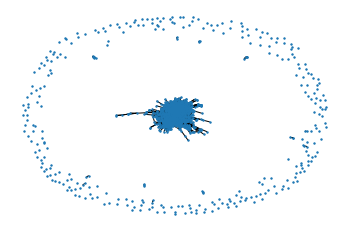

In [9]:
spring_pos = nx.spring_layout(G_simple)
plt.axis('off')
nx.draw_networkx(G_simple, pos=spring_pos, with_labels=False, node_size=2)

In [10]:
# Comparación del grado medio y la densidad de ambas redes
print(nx.info(G_simple))

Name: 
Type: Graph
Number of nodes: 1992
Number of edges: 10908
Average degree:  10.9518


In [11]:
print(nx.density(G_simple))

0.0055006565690184145


## Ejercicio 3. Cepa el grafo
Con esta fuente de datos es probable que tengamos varias componentes inconexas. Vamos a quedarnos con la componente más grande:

1. Utiliza la función nx.connected_components para recuperar las distintas componentes conexas de nuestro grafo

2. Utiliza el método subgraph del grafo para crear un nuevo grafo únicamente con la mayor componente conexa detectada

In [9]:
# Según la documentación, la manera más eficaz de conseguir el componente del grafo más grande es la siguiente:
largest_cc = max(nx.connected_components(G_simple), key=len)

In [10]:
G_simple = G_simple.subgraph(largest_cc)

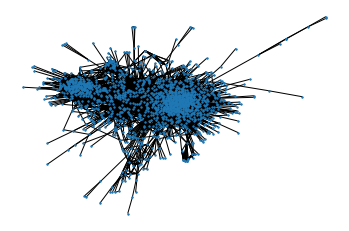

In [16]:
spring_pos = nx.spring_layout(G_simple)
plt.axis('off')
nx.draw_networkx(G_simple, pos=spring_pos, with_labels=False, node_size=2)

## Ejercicio 4. Centralidad de la red
Ahora vamos a analizar la centralidad de la red:

1. Calcula la centralidad de intermediación de la red y visualiza los nodos con mayor valor

2. Calcula la centralidad de Katz (pagerank o la centralidad de valor propio deberíand dar igual resultado) y visualiza la posición de los nodos de mayor valor


In [48]:
bt = nx.betweenness_centrality(G_simple)

In [54]:
bt_list = [(id, b) for id, b in bt.items()]
centrality_df = pd.DataFrame(bt_list, columns = ['node', 'centrality'])

In [63]:
centrality_df['color_final'] = 0
centrality_df.color_final[centrality_df.centrality >= 0.01] = 500

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


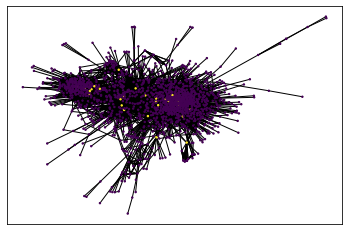

In [65]:
nx.draw_networkx(G_simple, pos=spring_pos, with_labels=False, node_size=2, node_color = centrality_df.color_final.values)

In [68]:
# Ahora haremos lo mismo pero con la centralidad de Katz
ka = nx.pagerank(G_simple)
bt_list_kantz = [(id, b) for id, b in ka.items()]
centrality_kantz_df = pd.DataFrame(bt_list_kantz, columns = ['node', 'centrality_kantz'])

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


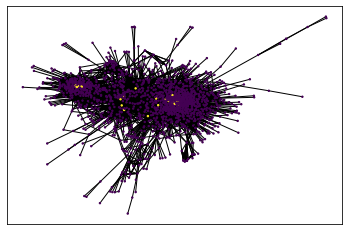

In [82]:
centrality_kantz_df['color_final'] = 0
centrality_kantz_df.color_final[centrality_kantz_df.centrality_kantz >= 0.002] = 500
nx.draw_networkx(G_simple, pos=spring_pos, with_labels=False, node_size=2, node_color = centrality_kantz_df.color_final.values)

## Ejercicio 5. Vuelve a conectar a la red y recupera info de los ids con mayor importancia

In [ ]:
# En el primer caso, los id's con mayor importancia son:


In [96]:
bt = centrality_df[centrality_df.color_final == 500]
bt

,node,centrality,color_final
79,26550607,0.013091,500
105,2937553380,0.015304,500
184,830908366377611264,0.016055,500
243,407807118,0.010867,500
270,822215679726100480,0.016044,500
285,14247236,0.027150,500
303,899762805204713472,0.020363,500
361,58525387,0.010898,500
439,799282709000556544,0.020382,500
562,2981776113,0.010454,500


In [103]:
# steps not shown where you set up api
for node in bt.node:
    print(node)
    try: 
        u = api.get_user(node)
        print (u.screen_name)
    except tweepy.TweepError: 
        pass

26550607
marketman52
2937553380
skeeter19592
830908366377611264
407807118
Limmered
822215679726100480
POTUS
14247236
funder
899762805204713472
GortTheGiant
58525387
Mooncatadams
799282709000556544
Trump_Girl_2020
2981776113
blaze0497
1963740164
lewlester
240454812
GenFlynn
15764644
SpeakerPelosi
1255516313394589696
1028041029763706880
2421067430
TeaPainUSA
17494010
SenSchumer
115749048
SecretService
785094175167361024
Texas_Trump
935177547234422784
33378935
Jersey327
4480906040
trump_sylvia
822215673812119552
939091
JoeBiden
1082031161076002816
KathyVotesRed
759251
CNN
62543444
poettinger
25073877
realDonaldTrump
852290631804362752
Julfcr7


In [104]:
bt_kantz = centrality_kantz_df[centrality_kantz_df.color_final == 500]
for node in bt_kantz.node:
    print(node)
    try: 
        u = api.get_user(node)
        print (u.screen_name)
    except tweepy.TweepError: 
        pass

15220768
DavidCornDC
505226042
NationalistLou
830908366377611264
822215679726100480
POTUS
14247236
funder
27493883
joncoopertweets
799282709000556544
Trump_Girl_2020
15976705
Amy_Siskind
65497475
eugenegu
1028041029763706880
2421067430
TeaPainUSA
17494010
SenSchumer
115749048
SecretService
1137823130720919552
785094175167361024
Texas_Trump
935177547234422784
4480906040
trump_sylvia
822215673812119552
939091
JoeBiden
759251
CNN
1263246263509643264
43784241
mickelodoole
25073877
realDonaldTrump
22771961
Acosta
1110502052554309632
245800387
Tracie0313


## Ejercicio 6. Analiza las comunidades que aparecen en el grafo

Utiliza el módulo python-louvain para ver qué comunidades aparecen en la red (recuerda que se importa como community una vez instalado). Después visualízala



In [2]:
#!pip install python-louvain - import community

In [11]:
parts = community.best_partition(G_simple)
communities = set (parts.values())
members = {c:[] for c in communities}
for id, c in parts.items():
    members[c].append(id)

In [12]:
for c, m in members.items():
    print(f'Comunidad {c}: {len(m)} elementos')

Comunidad 0: 736 elementos
Comunidad 1: 406 elementos
Comunidad 2: 205 elementos
Comunidad 3: 4 elementos
Comunidad 4: 53 elementos
Comunidad 5: 18 elementos
Comunidad 6: 70 elementos
Comunidad 7: 2 elementos
Comunidad 8: 85 elementos
Comunidad 9: 56 elementos
Comunidad 10: 4 elementos
Comunidad 11: 2 elementos
Comunidad 12: 3 elementos
Comunidad 13: 9 elementos
Comunidad 14: 4 elementos
Comunidad 15: 3 elementos
Comunidad 16: 2 elementos
Comunidad 17: 2 elementos


In [13]:
colores = [parts[n] for n in G_simple.nodes()]

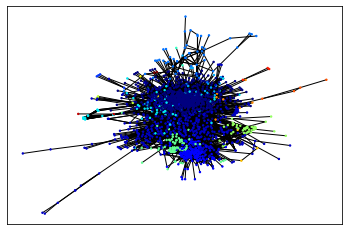

In [15]:
spring_pos = nx.spring_layout(G_simple)
nx.draw_networkx(G_simple, pos=spring_pos, cmap=plt.get_cmap('jet'), node_color=colores, node_size=2, with_labels=False)

In [16]:
# No parece que en el grafo se idenfican claramente los grupos que se identifican.
# Veremos si entre los grupos más numerosos que relación tienen.

## Ejercicio 7. Recupera la lista de usuarios más importantes de cada comunidad

1. Recupera la lista de los usuarios con más importancia en cada comunidad (primero necesitas la lista de usuarios de cada comunidad y luego ordénalo por importancia)

2. Conéctate a la API de Twitter e identifica los usuarios que aparecen ¿Se pueden identificar las comunidades que se han generado?

3. ¿Qué criterio de centralidad utilizarás para identificar a los usuarios más representativos? ¿Qué usuarios aparecen con los mayores valores de centralidad de intermediación?


Vamos identificar los usuarios que hay en cada comunidad

Los resultados obtenidos han sido:

    Comunidad 0: 736 elementos
    Comunidad 1: 406 elementos
    Comunidad 2: 205 elementos
    Comunidad 3: 4 elementos
    Comunidad 4: 53 elementos
    Comunidad 5: 18 elementos
    Comunidad 6: 70 elementos
    Comunidad 7: 2 elementos
    Comunidad 8: 85 elementos
    Comunidad 9: 56 elementos
    Comunidad 10: 4 elementos
    Comunidad 11: 2 elementos
    Comunidad 12: 3 elementos
    Comunidad 13: 9 elementos
    Comunidad 14: 4 elementos
    Comunidad 15: 3 elementos
    Comunidad 16: 2 elementos
    Comunidad 17: 2 elementos
    
Por criterio me voy a quedar con las comunidades de más de 50 elementos, por tanto:
    - Comunidad 0
    - Comunidad 1
    - Comunidad 2
    - Comunidad 6
    - Comunidad 8
    - Comunidad 9
  

In [71]:
coms = pd.DataFrame(parts.items(),columns=['node','com'])
coms['centrality'] = 0

In [55]:
# Calculemos la centralidad de la red de nuevo
bt = nx.betweenness_centrality(G_simple)
bt_list = [(id, b) for id, b in bt.items()]
#bt_list_ord = sorted(bt_list, key=lambda b: b[1], reverse=True)

In [73]:
for node in coms.node.values : 
    coms.centrality[coms.node == node] = bt[node]

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [74]:
coms

,node,com,centrality
0,828997388920619008,0,0.000485
1,1247231730806816768,0,0.001519
2,725056222009909248,0,0.002745
3,1136694950488432640,0,0.003200
4,1247638843467186176,0,0.000834
...,...,...,...
1659,2289770467,0,0.000000
1660,246939630,0,0.000012
1661,1205892235495165952,2,0.000264
1662,1387028468,4,0.000485


In [88]:
# Ahora vamos a dividirlos por comunidades

def show_rel_users(df, com):
    print(f'Estos son los usuarios más relavantes de la comunidad {com}')
    print('------------------------------------------------------------')
    for node in df.node.values:
        try: 
            u = api.get_user(node)
            print (u.screen_name)
        except tweepy.TweepError as e: 
            print(e)
    print('\n')

# Comunidad 0
com_0 = coms[coms.com == 0]
relevantes_0 = com_0.sort_values(by=['centrality'], ascending = False)[0:10]
show_rel_users(relevantes_0, 0)          


# Comunidad 1
com_1 = coms[coms.com == 1]
relevantes_1 = com_1.sort_values(by=['centrality'], ascending = False)[0:10]
show_rel_users(relevantes_1, 1)   

# Comunidad 2
com_2 = coms[coms.com == 2]
relevantes_2 =com_2.sort_values(by=['centrality'], ascending = False)[0:10]
show_rel_users(relevantes_2, 2)   

# Comunidad 6
com_6 = coms[coms.com == 6]
relevantes_6 =com_6.sort_values(by=['centrality'], ascending = False)[0:10]
show_rel_users(relevantes_6, 6)   

# Comunidad 8
com_8 = coms[coms.com == 8]
relevantes_8 =com_8.sort_values(by=['centrality'], ascending = False)[0:10]
show_rel_users(relevantes_8, 8)   

# Comunidad 9
com_9 = coms[coms.com == 9]
relevantes_9 =com_9.sort_values(by=['centrality'], ascending = False)[0:10]
show_rel_users(relevantes_9, 9)   

Estos son los usuarios más relavantes de la comunidad 0
------------------------------------------------------------
realDonaldTrump
SecretService
funder
SenSchumer
CNN
JoeBiden
[{'code': 50, 'message': 'User not found.'}]
TeaPainUSA
GenFlynn
SpeakerPelosi


Estos son los usuarios más relavantes de la comunidad 1
------------------------------------------------------------
[{'code': 50, 'message': 'User not found.'}]
Texas_Trump
trump_sylvia
Trump_Girl_2020
POTUS
[{'code': 50, 'message': 'User not found.'}]
[{'code': 50, 'message': 'User not found.'}]
DonCorneliano2
[{'code': 50, 'message': 'User not found.'}]
[{'code': 50, 'message': 'User not found.'}]


Estos son los usuarios más relavantes de la comunidad 2
------------------------------------------------------------
Jersey327
GortTheGiant
poettinger
skeeter19592
[{'code': 50, 'message': 'User not found.'}]
blaze0497
[{'code': 50, 'message': 'User not found.'}]
rebson4683
missilynn54
[{'code': 50, 'message': 'User not found.'}]


E

Apreciaciones de los componentes de las comunidades:

Comunidad 0
---
| screen_name | Observaciones |
| -- | -- |
| realDonaldTrump | Es la cuenta oficial de Trump |
| SecretService | Cuenta oficial del servicio secreto de US |
| funder | Scott Dwoking, fundador de 'Democratic Coalition Against Trump, vinculación partido demócrata |
| SenSchumer | New York's Senator and Senate Democratic Leader |
| CNN | Medio de Comunicación |
| JoeBiden | Posible candidato a las elecciones de US por partido demócrata |
| TeaPainUSA | Cuenta contra-Trump. Pide voto partido demócrata |
| GenFlynn | Exconsejero de Seguridad Nacional de US en etapa Trump |
| SpeakerPelosi | Speaker de congreso de US - Demócrata |

En su mayoría son políticos afines o no a la administración Trump. Destaca que la mayoría de políticos extraídos en esta comunidad están en __contra__ de Trump. No hay cargos del partido republicano que se expongan tanto. Se ve eclipsada por la máxima presencia mediática de Trump a través de su cuenta de Twitter, que podría eclipsar la la presencia de sus socios republicanos.


Comunidad 1
----------
| screen_name | observaciones |
| -- | -- |
| Texas_Trump | Cuenta de apoyo a Trump. Gran parte de su timeline hace referencia a la actitud negativa y violenta de la población afroamericana en lso disturbios ocurridos durante el 30 de Mayo 2020 | Cuenta de apoyo a Trum. De nuevo gran parte del contenido que comparte hace referencia a los disturbios debibo a problemas raciales |
| Trump_Girl_2020 | Cuenta de apoyo a Trump |
| realDonaldTrump | Segunda cuenta oficial de Trump |
| DonCorneliano2 | Cuenta apoyo Trum. Lo más curioso es que está en español |





Comunidad 2
----

| screen_name | observaciones |
| -- | -- |
| Jersey327 | Cuenta de apoyo a Trump |
| GortTheGiant | Cuenta de apoyo a Trump |
| poettinger | Cuenta de apoyo a Trump |
| skeeter19592 | Policía. Trump Supporter |
| blaze0497 | Trump supporter |
| missilynn54 | Trump supporter |




Comunidad 6
--------------

| screen_name | observaciones |
| -- | -- |
| marketman52 | Anti-Trump Resisteer |
| Limmered | Partido demócrata supporter |
| trom771 | Partido Demócrata supporter |
| PuffDomino | Crítica constante a Trump |
| AllanMargolin | Anti-Trump | 


Comunidad 8 
-----------

| screen_name | observaciones |
| -- | -- |
| KathyVotesRed | Trump Supporter |
| neuro7plastic | Trump Supporter |
| PoliticalIntent | Trump Supporter |
| galacticaactual | Trump Supporter |



Comunidad 9
------ 

| screen_name | observaciones |
| -- | -- |
| lewlester | Trump Supporter |
| _Elissamorand_ | Sus tweets están continuamente hablando de los riots |
| klc4_trump | Trump Supporter |
| donlusin | Anti Democrats|



Como resultado hemos obtenido que:

      1- Comunidad 1: 736 elementos - Destaca a nivel institucional. Las cuentas más relevantes están compuestas por la cuenta oficial de Trump, y por cargos republicanos o democrátas
      2- Comunidades 1(406), 2(205), 8(85), 9(56): Cuentas de apoyo a Trump
      3- Comunidad 6 (70): Cuentas anti-Trump